In [1]:
# RNN을 활용한 시계열 데이터 처리
if '__file__' in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), '..'))

import numpy as np
import matplotlib.pyplot as plt
import dezero
from dezero import Model
import dezero.functions as F
import dezero.layers as L

![그림 59-1](./img/59-1.png)    
RNN에 데이터가 입력되면 상태가 갱신되고 그 상태도 출력에 영향을 준다.

![식 59.1](./img/59.1.png)  
입력 $x_{i}$, 은닉 상태 h로 변환하기 위한 가중지 $W_{x}$, RNN의 출력을 다음 시각의 출력으로 변환하기 위한 가중치 $W_{h}$, 편향 b  
($h_{t-1}$ 과 $x_{i}$ 는 행벡터)    
결과값은 시각t에서의 출력 $h_{t}$. 이 $h_{t}$는 연결된 다음 계층의 입력으로 사용되는 동시에 다음 시각의 RNN 계층(자기 자신)의 입력으로도 사용

In [ ]:
# RNN 계층 구현
class RNN(Layer):
    def __init__(self, hidden_size, in_size=None):
        """An Elman RNN with tanh.

        Args:
            hidden_size (int): The number of features in the hidden state.
            in_size (int): The number of features in the input. If unspecified
            or `None`, parameter initialization will be deferred until the
            first `__call__(x)` at which time the size will be determined.

        """
        super().__init__()
        self.x2h = Linear(hidden_size, in_size=in_size)         # 입력 x에서 은닉 상태 h로 변환하는 완전연결계층
        self.h2h = Linear(hidden_size, in_size=in_size, nobias=True)        # 이전 은닉 상태에서 다음 은닉 상태로 변환하는 완전연결계층
        self.h = None

    def reset_state(self):     # 은닉 상태 재설정 메서드
        self.h = None

    def forward(self, x):
        if self.h is None:
            h_new = F.tanh(self.x2h(x))         # 입력 x만으로 은닉 상태 계산
        else:   
            h_new = F.tanh(self.x2h(x) + self.h2h(self.h))      # 앞서 저장해둔 은닉 상태를 사용하여 새로운 은닉 상태를 계산
        self.h = h_new
        return h_new

In [8]:
import numpy as np 
import dezero.layers as L 

rnn = L.RNN(10)     # 은닉층 크기만 지정
x = np.random.rand(1,1)     # 배치크기가 1인 1차원 데이터
h = rnn(x)

print(h, h.shape)

variable([[-0.17976565 -0.23350658  0.23695289 -0.16123581  0.00143558 -0.53839521
           -0.39522256 -0.07642805  0.03822666 -0.31968937]]) (1, 10)


![그림 59-2](./img/59-2.png)    
![그림 59-3](./img/59-3.png)

| epoch 1 | loss 0.350130
| epoch 2 | loss 0.086933
| epoch 3 | loss 0.054329
| epoch 4 | loss 0.012431
| epoch 5 | loss 0.003690
| epoch 6 | loss 0.002728
| epoch 7 | loss 0.002186
| epoch 8 | loss 0.002141
| epoch 9 | loss 0.002002
| epoch 10 | loss 0.001969
| epoch 11 | loss 0.001948
| epoch 12 | loss 0.001990
| epoch 13 | loss 0.002059
| epoch 14 | loss 0.002227
| epoch 15 | loss 0.002449
| epoch 16 | loss 0.002776
| epoch 17 | loss 0.003155
| epoch 18 | loss 0.003532
| epoch 19 | loss 0.003850
| epoch 20 | loss 0.004101
| epoch 21 | loss 0.004304
| epoch 22 | loss 0.004467
| epoch 23 | loss 0.004582
| epoch 24 | loss 0.004643
| epoch 25 | loss 0.004660
| epoch 26 | loss 0.004651
| epoch 27 | loss 0.004630
| epoch 28 | loss 0.004603
| epoch 29 | loss 0.004571
| epoch 30 | loss 0.004535
| epoch 31 | loss 0.004497
| epoch 32 | loss 0.004459
| epoch 33 | loss 0.004421
| epoch 34 | loss 0.004384
| epoch 35 | loss 0.004348
| epoch 36 | loss 0.004316
| epoch 37 | loss 0.004291
| epoch 38

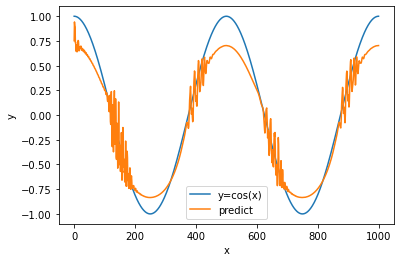

In [3]:
# 사인파 예측
import numpy as np
import matplotlib.pyplot as plt
import dezero
from dezero import Model
import dezero.functions as F
import dezero.layers as L

# Hyperparameters
max_epoch = 100
hidden_size = 100
bptt_length = 30

train_set = dezero.datasets.SinCurve(train=True)
seqlen = len(train_set)


class SimpleRNN(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.rnn = L.RNN(hidden_size)
        self.fc = L.Linear(out_size)

    def reset_state(self):
        self.rnn.reset_state()      # 은닉 상태를 재설정

    def __call__(self, x):
        h = self.rnn(x)
        y = self.fc(h)
        return y


model = SimpleRNN(hidden_size, 1)
optimizer = dezero.optimizers.Adam().setup(model)

# Start training.
for epoch in range(max_epoch):
    model.reset_state()
    loss, count = 0, 0

    for x, t in train_set:
        x = x.reshape(1, 1)
        y = model(x)
        loss += F.mean_squared_error(y, t)
        count += 1

        if count % bptt_length == 0 or count == seqlen:
            model.cleargrads()
            loss.backward()
            loss.unchain_backward()
            optimizer.update()

    avg_loss = float(loss.data) / count
    print('| epoch %d | loss %f' % (epoch + 1, avg_loss))

# Plot
xs = np.cos(np.linspace(0, 4 * np.pi, 1000))
model.reset_state()
pred_list = []

with dezero.no_grad():
    for x in xs:
        x = np.array(x).reshape(1, 1)
        y = model(x)
        pred_list.append(float(y.data))

plt.plot(np.arange(len(xs)), xs, label='y=cos(x)')
plt.plot(np.arange(len(xs)), pred_list, label='predict')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()